## AIN313 - Assignment 3
## Instructor: M. Erkut Erdem
## Asistant: Sibel Kapan
## Topic: Neural Networks and Convolutional Neural Networks
## Subject: Classification of Flower Species using Neural Network
## Student Info: Can Ali Ateş
## Student ID: 2200765002


## PART I - Theory Questions

![Question1](https://drive.google.com/uc?id=143qoNBDW22nMBOp12skF_cPE5w0YvQSR)

### Calculations:

#### CONV3-10:
* $\frac{(64-3)}{2} + 1 = 31.5$ so we will round down to 31 ---> Output Volume Shape = (31x31x10) <br>

* 3 x 3 x 4 x 10 + 10 = 370 Parameters <br><br>

#### POOL-2:
* $\frac{(31-2)}{2} + 1 = 15.5$ so we will round down to 15 ---> Output Volume Shape = (15x15x10) <br>

* POOL contains 0 Parameters. <br><br>

#### CONV3-10:
* $\frac{(15-3)}{2} + 1 = 7$ ---> Output Volume Shape = (7x7x10) <br>

* 3 x 3 x 10 x 10 + 10 = 910 Parameters <br><br>

#### POOL-2: 
* $\frac{(7-2)}{2} + 1 = 3.5$ so we will round down to 3 ---> Output Volume Shape = (3x3x10) <br>

* POOL contains 0 Parameters. <br><br>

#### FC-20:
* Output Volume Shape = (20x1) <br>

* 3 x 3 x 10 x 20 + 20 = 1820 Parameters <br><br>

#### FC-10:
* Output Volume Shape = (10x1) <br>

* 20 x 10 + 10  = 210 Parameters <br><br>

#### Answer 1:
![Answer1](https://drive.google.com/uc?id=1kmF89GDDb5MvQOmRAhd24Ey4Rs93_Z5f)

<br><br>

![Question2](https://drive.google.com/uc?id=1DC7EH5rSjQw5m9QgZpzf7BTt8rM2BTWy)

#### Answer 2:

#### $I_1$ = $3.(1) + 5.(0) + 2.(0) = 3$ so $y = 1$ because $3 > 0$ <br>

#### $I_2$ = $3.(0) + 5.(1) + 2.(1) = 7$ so $y = 1$ because $7 > 0$ <br>

#### $I_3$ = $3.(1) + 5.(0) + 2.(1) = 5$ so $y = 1$ because $5 > 0$ <br>

#### $I_4$ = $3.(1) + 5.(1) + 2.(1) = 10$ so $y = 1$ because $10 > 0$ <br> <br>

![Question3](https://drive.google.com/uc?id=1tfdwz8O7RXI_XH4zbhJda-KhCNQh8vux)

#### Answer 3:

#### The network is Fully Connected already, so premise 1 and 2 answers are same.

* **3 x 5 + 5 x 3 + 3 x 2 = 36 Weights in total.**

#### Forward Propogation

* Node 1 = $w_{00}.x_1 + w_{01}.x_2 + w_{02}.x_3$

* $w_{ij}$ respresents:
  * i as previous node number.
  * j as $j^{th}$ edge of node i connected to actual node.

We can calculate all the other nodes as Node 1 for Forward Propagation. <br> <br>

#### Backward Propagation

* Activation Function ($w_{ij}^{layer+1}$ x $activation_j^{layer}$)

* $d_j = \Sigma_{i}(d_i^{layer+1}$ x $a_i^{layer+1}(1-a_i^{layer+1})x_{ij}^{layer+1}$ is error that propagates in backward propagation. 

* **As a result, while the neurons gain information from previous hidden layer neurons for the forward propagation; in the backward progation they gains information from the next hidden layer neurons.**


# PART II - Classification of Flower Species using Neural Network

**Dataset Downloading**

In [ ]:
# Update G-Down to avoid possible errors.
!pip install --upgrade --no-cache-dir gdown

# Download the dataset from Google Drive to Google Colab.
!gdown --id 1PyTLK4lCJR7kvntCTxyiTSU5vegDw2dz

# Extract zip files.
!unzip "flowers.zip" 

**Data Loading**

In [ ]:
def data_load(image_size, batch_size): 
    
    # Create Transformers
    main_transformer = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.554, 0.450, 0.343], [0.231, 0.241, 0.241])
    ])

    aug_transformer = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.1, 0.1, 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.554, 0.450, 0.343], [0.231, 0.241, 0.241]),
        transforms.RandomErasing()
    ])

    # Create Datasets
    train_dataset = datasets.ImageFolder('/content/flowers/train', transform=aug_transformer)
    test_dataset = datasets.ImageFolder('/content/flowers/test', transform=main_transformer)

    # Crete Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Return Hyperparameters and Data Loads.
    return image_size, batch_size, train_loader, test_loader

**Importing Necessary Libraries**

In [ ]:
import os
import numpy as np
import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

## Multi Layer Neural Network Part

**Multi Layer Neural Network Implementation**

In [ ]:
class NeuralNet(nn.Module):

    # Initialize the Neural Network.
    def __init__(self, image, activation, hidden):
      super(NeuralNet, self).__init__()
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.train_loss = []
      self.model = nn.Sequential()
      self.model.add_module('flatten', nn.Flatten())
      self.model.add_module('input', nn.Linear(image*image*3, hidden[0], device = self.device)) # RGB
      self.model.add_module('activate', activation)
      for i in range(len(hidden) - 1):
        self.model.add_module(f'hidden_{i}', nn.Linear(hidden[i], hidden[i+1]))
        self.model.add_module(f'activate_{i}', activation)
      self.model.add_module('output', nn.Linear(hidden[-1], 7, device = self.device))

    # Run the Model.
    def train(self, optimizer_type, learning_rate, train, batch_size): 
        # Connect model to CUDA.
        self.model.to(self.device)
        # Determine Loss and Optimizer.
        loss_func = nn.CrossEntropyLoss()
        if optimizer_type == 'adam':
          optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        elif optimizer_type == 'sgd':
          optimizer = optim.SGD(self.model.parameters(), lr = learning_rate)

        # Run Epochs.
        for epoch in range(10):
            total_loss = 0
            correct = 0
            for batch in (train):
                # Grads = 0 before starting.
                optimizer.zero_grad()
                # Arrange Data.
                images = batch[0].to(self.device)
                labels = batch[1].to(self.device)
                # Forward Propagation.
                output = self.model(images)
                loss = loss_func(output, labels)
                total_loss += loss.item()
                _, preds = torch.max(output, 1)
                correct += (preds == labels).sum().item()
                # Backward Propagation.
                loss.backward()
                optimizer.step()
            # Train Loss on Each Epoch.
            self.train_loss.append(total_loss/(len(train)*batch_size))

    # Test The Model     
    def test(self, test):
        self.model.to(self.device)
        self.model.eval()
        correct = 0
        with torch.no_grad():
            for batch in (test):
                images = batch[0].to(self.device)
                labels = batch[1].to(self.device)
                output = self.model(images)
                _, preds = torch.max(output.data, 1)
                correct += (preds == labels).sum().item()
            return correct / len(test.dataset)

### One Hidden Layer Neural Network Experiments

**Experiments**

In [ ]:
# List to Hold Train Losses of Each Experiment.
experiment_losses = []

# Test the Single Layer Neural Network with Different Parameters.
for batch_size in [32, 64]:
    image_size, batch_size, train_loader, test_loader = data_load(32, batch_size)
    for neuron_count in [50, 100]:
        for i, activator in enumerate([nn.ReLU(), nn.Tanh()]):
            for learning_rate in [0.010, 0.020]:
                for optimizer_type in ['adam', 'sgd']:
                    model = NeuralNet(image_size, activator, [neuron_count])
                    model.train(optimizer_type, learning_rate, train_loader, batch_size)
                    experiment_losses.append(model.train_loss)
                    accuracy = model.test(test_loader)
                    print(f"Batch Size: {batch_size}    Neuron: {str(neuron_count):3}   Activation: {'ReLU' if i == 0 else 'TanH'}    Learning Rate: {learning_rate}    Optimizer: {optimizer_type.capitalize():4}    Test Accuracy: {accuracy:.3f}")

Batch Size: 32    Neuron: 50    Activation: ReLU    Learning Rate: 0.01    Optimizer: Adam    Test Accuracy: 0.349
Batch Size: 32    Neuron: 50    Activation: ReLU    Learning Rate: 0.01    Optimizer: Sgd     Test Accuracy: 0.546
Batch Size: 32    Neuron: 50    Activation: ReLU    Learning Rate: 0.02    Optimizer: Adam    Test Accuracy: 0.213
Batch Size: 32    Neuron: 50    Activation: ReLU    Learning Rate: 0.02    Optimizer: Sgd     Test Accuracy: 0.486
Batch Size: 32    Neuron: 50    Activation: TanH    Learning Rate: 0.01    Optimizer: Adam    Test Accuracy: 0.414
Batch Size: 32    Neuron: 50    Activation: TanH    Learning Rate: 0.01    Optimizer: Sgd     Test Accuracy: 0.524
Batch Size: 32    Neuron: 50    Activation: TanH    Learning Rate: 0.02    Optimizer: Adam    Test Accuracy: 0.364
Batch Size: 32    Neuron: 50    Activation: TanH    Learning Rate: 0.02    Optimizer: Sgd     Test Accuracy: 0.526
Batch Size: 32    Neuron: 100   Activation: ReLU    Learning Rate: 0.01    Optim

**Training Loss Graphs**

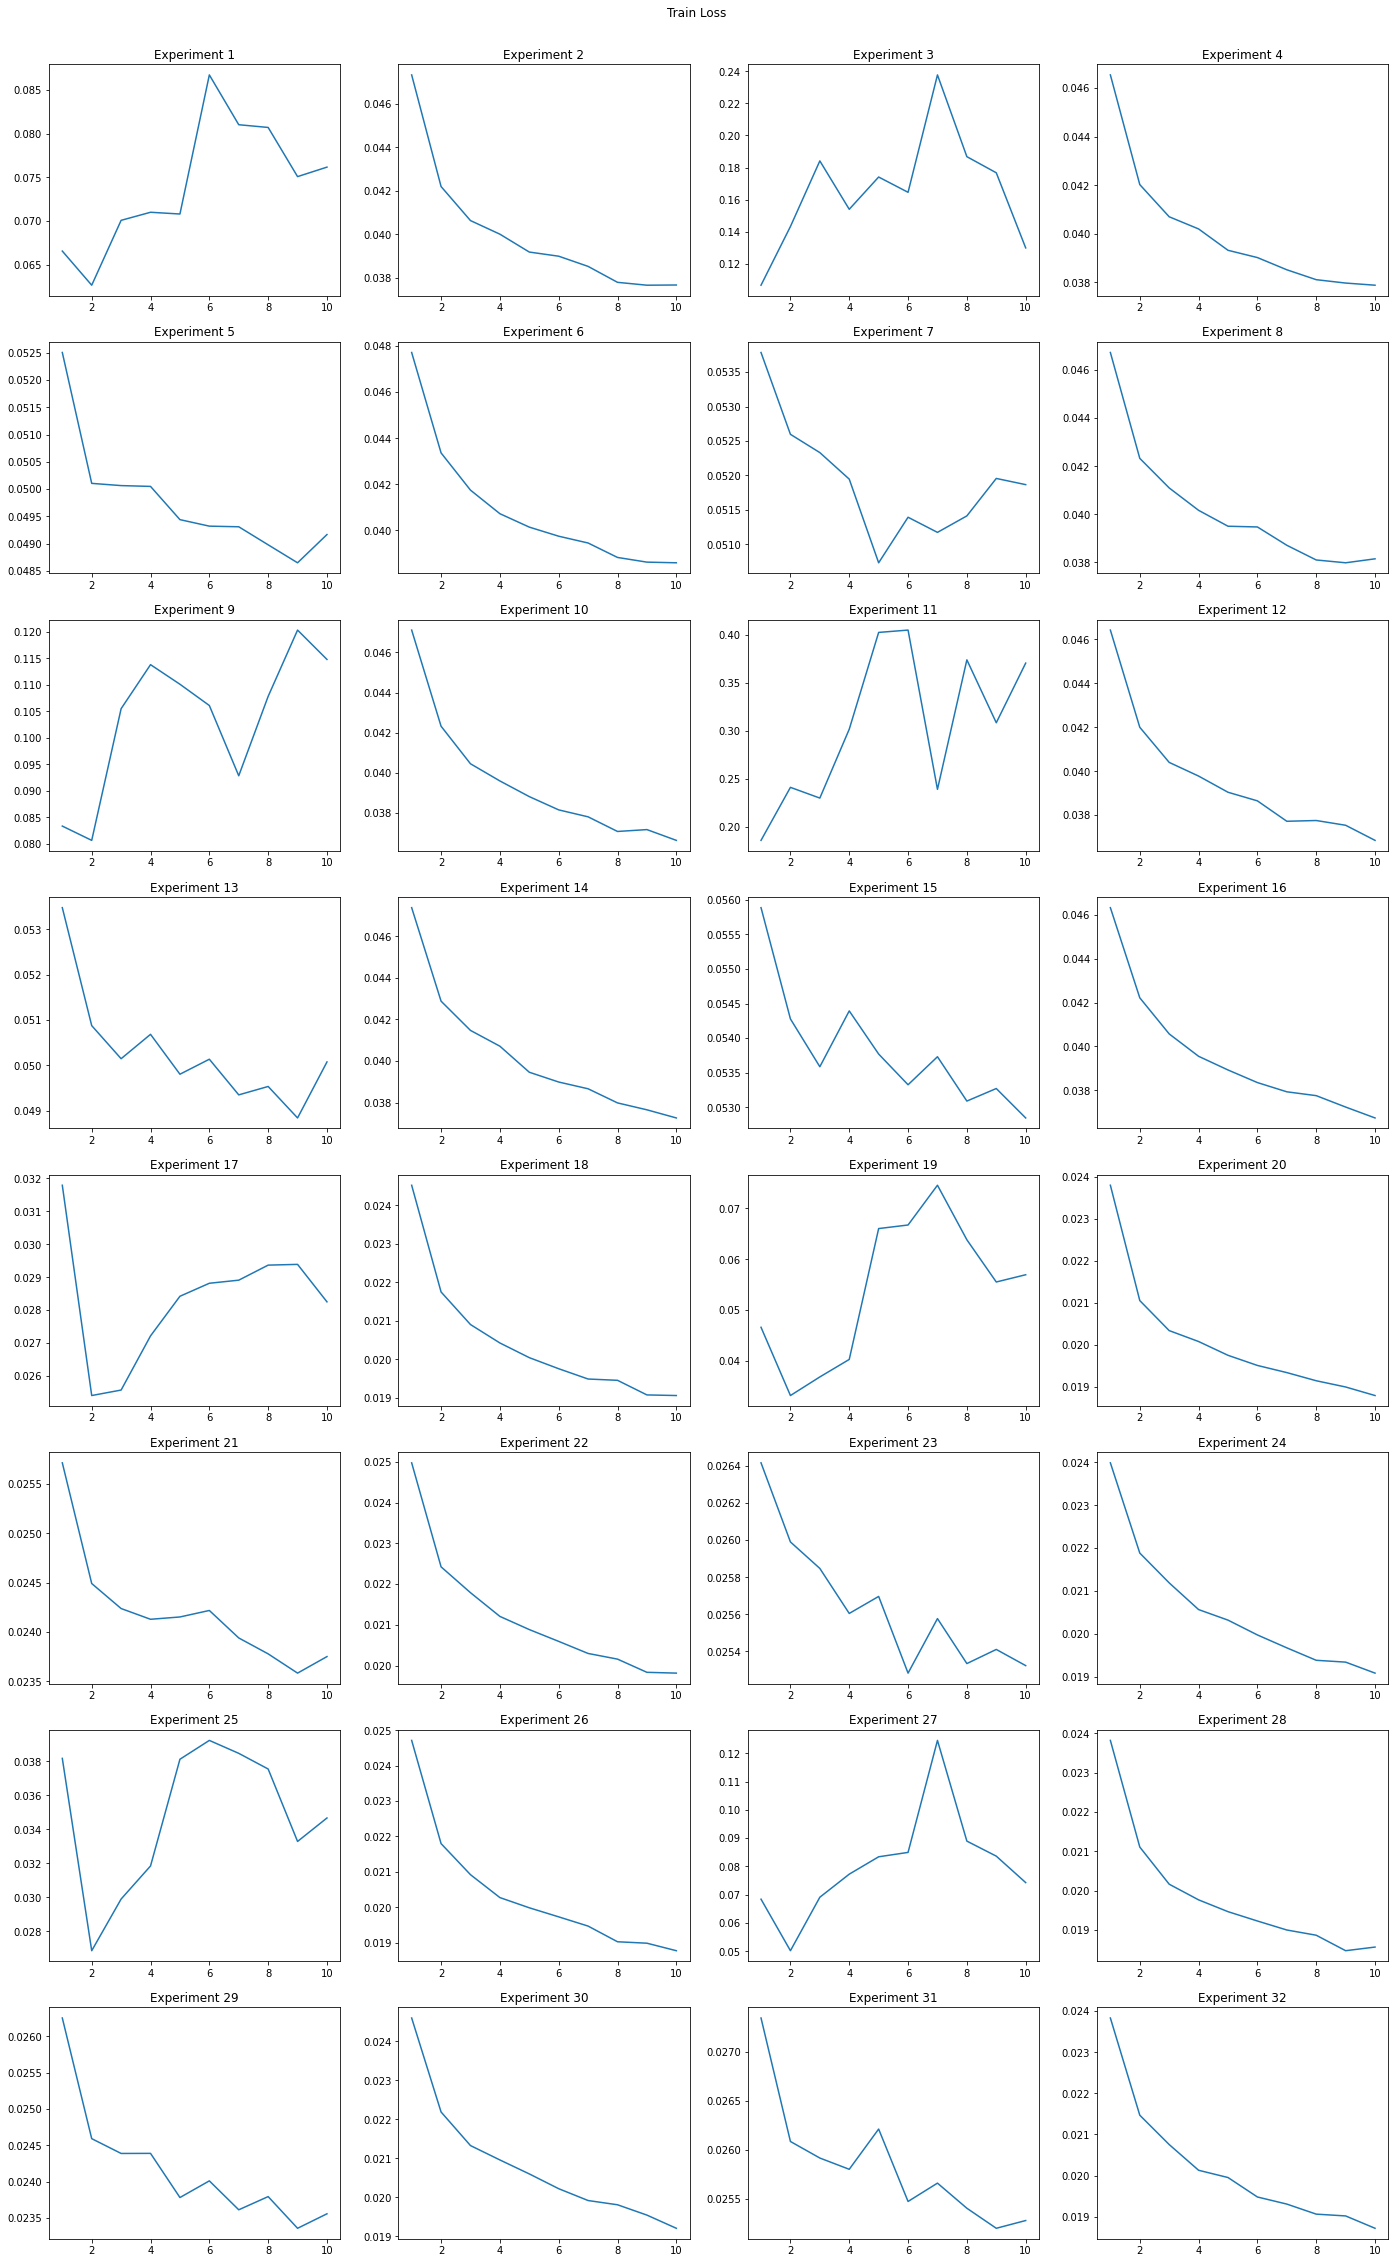

In [ ]:
# Plot the Training Loss Graphs of Experiments.
fig = plt.figure(figsize=(24, 40))

for i in range(1, len(experiment_losses) + 1):
    plt.subplot(8, 4, i).set_title(f'Experiment {i}')
    plt.plot(range(1, 11), experiment_losses[i-1])

plt.suptitle("Train Loss", y = 0.9)
plt.show()

### Two Hidden Layer Neural Network Experiments

**Experiments**

In [ ]:
# List to Hold Train Losses of Each Experiment.
experiment_losses = []

# Test the Single Layer Neural Network with Different Parameters.
for batch_size in [32, 64]:
    image_size, batch_size, train_loader, test_loader = data_load(32, batch_size)
    for neuron_count in [[40, 80], [50, 100]]:
        for i, activator in enumerate([nn.ReLU(), nn.Tanh()]):
            for learning_rate in [0.010, 0.020]:
                    model = NeuralNet(image_size, activator, [neuron_count[0], neuron_count[1]])
                    model.train('sgd', learning_rate, train_loader, batch_size)
                    experiment_losses.append(model.train_loss)
                    accuracy = model.test(test_loader)
                    print(f"Batch Size: {batch_size}    Neuron: {str(neuron_count):9}   Activation: {'ReLU' if i == 0 else 'TanH'}    Learning Rate: {learning_rate}    Optimizer: Sgd    Test Accuracy: {accuracy:.3f}")

Batch Size: 32    Neuron: [40, 80]    Activation: ReLU    Learning Rate: 0.01    Optimizer: Sgd    Test Accuracy: 0.535
Batch Size: 32    Neuron: [40, 80]    Activation: ReLU    Learning Rate: 0.02    Optimizer: Sgd    Test Accuracy: 0.544
Batch Size: 32    Neuron: [40, 80]    Activation: TanH    Learning Rate: 0.01    Optimizer: Sgd    Test Accuracy: 0.531
Batch Size: 32    Neuron: [40, 80]    Activation: TanH    Learning Rate: 0.02    Optimizer: Sgd    Test Accuracy: 0.536
Batch Size: 32    Neuron: [50, 100]   Activation: ReLU    Learning Rate: 0.01    Optimizer: Sgd    Test Accuracy: 0.530
Batch Size: 32    Neuron: [50, 100]   Activation: ReLU    Learning Rate: 0.02    Optimizer: Sgd    Test Accuracy: 0.532
Batch Size: 32    Neuron: [50, 100]   Activation: TanH    Learning Rate: 0.01    Optimizer: Sgd    Test Accuracy: 0.536
Batch Size: 32    Neuron: [50, 100]   Activation: TanH    Learning Rate: 0.02    Optimizer: Sgd    Test Accuracy: 0.533
Batch Size: 64    Neuron: [40, 80]    Ac

**Training Loss Graphs**

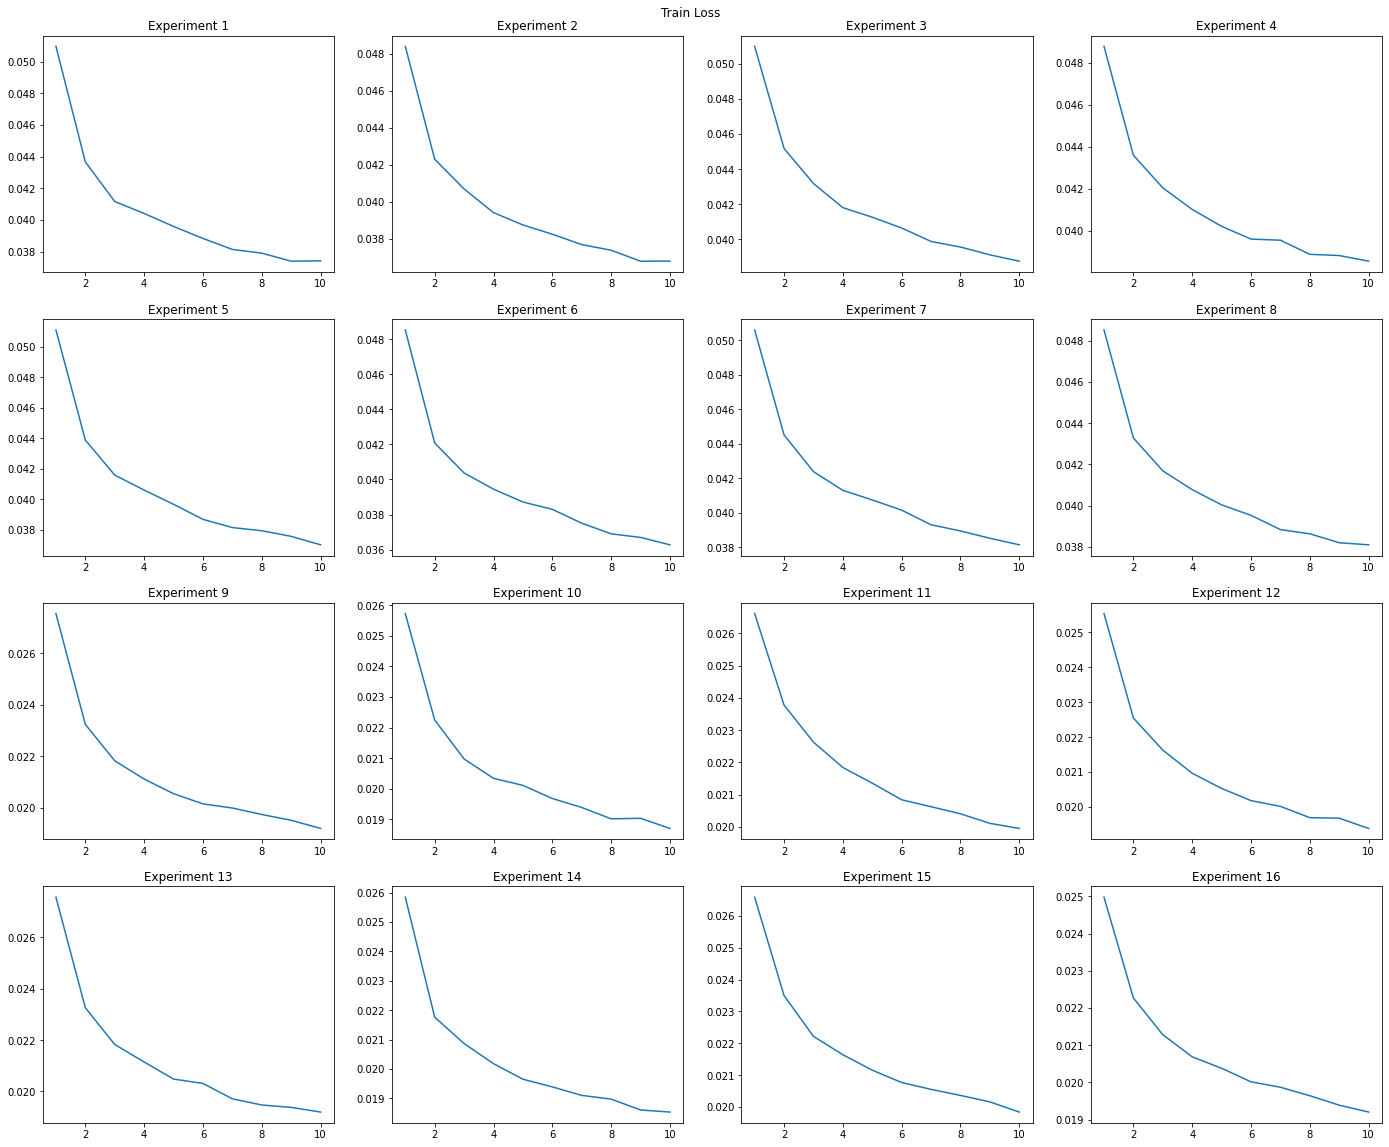

In [ ]:
# Plot the Training Loss Graphs of Experiments.
fig = plt.figure(figsize=(24, 20))

for i in range(1, len(experiment_losses) + 1):
    plt.subplot(4, 4, i).set_title(f'Experiment {i}')
    plt.plot(range(1, 11), experiment_losses[i-1])

plt.suptitle("Train Loss", y = 0.9)
plt.show()

## Convolutional Neural Network Part

**Convolutional Neural Network Implementations**

In [ ]:
# One Convolutional and One Fully Connected Layer.
def CNN_1(activator):
    # Set Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Build the Model
    model = nn.Sequential()
    model.add_module('convolutional', nn.Conv2d(in_channels=3, out_channels=9, kernel_size = 3, padding = 1, stride = 1))
    model.add_module('activate', activator)
    model.add_module('max_pool', nn.MaxPool2d(2,2))
    model.add_module('flatten', nn.Flatten())
    model.add_module('fully_connected', nn.Linear(2304, 7))
    return model

In [ ]:
# Two Convolutional and Two Fully Connected Layer.
def CNN_2(activator):
    # Set Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Build the Model
    model = nn.Sequential()
    model.add_module('convolutional', nn.Conv2d(in_channels=3, out_channels=9, kernel_size = 3, padding = 1, stride = 1))
    model.add_module('activate', activator)
    model.add_module('max_pool', nn.MaxPool2d(2,2))
    model.add_module('convolutional2', nn.Conv2d(in_channels=9, out_channels=12, kernel_size = 3, padding = 1, stride = 1))
    model.add_module('activate2', activator)
    model.add_module('max_pool2', nn.MaxPool2d(2,2))
    model.add_module('flatten', nn.Flatten())
    model.add_module('fully_connected', nn.Linear(768, 100))
    model.add_module('activate3', activator)
    model.add_module('fully_connected2', nn.Linear(100, 7))
    return model

In [ ]:
def train_cnn(model, optimizer_type, learning_rate, train):
    
    # Set Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss = []
    
    # Training
    loss_func = nn.CrossEntropyLoss()
    model.to(device)
    if optimizer_type == 'adam':
          optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    elif optimizer_type == 'sgd':
      optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    
    # Run Epochs.
    for epoch in range(10):
        total_loss = 0
        correct = 0
        for batch in (train):
            # Grads = 0 before starting.
            optimizer.zero_grad()
            # Arrange Data.
            images = batch[0].to(device)
            labels = batch[1].to(device)
            # Forward Propagation.
            output = model(images)
            loss = loss_func(output, labels)
            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()
            # Backward Propagation.
            loss.backward()
            optimizer.step()
        # Train Loss on Each Epoch.
        train_loss.append(total_loss/(len(train)*batch_size))

    return train_loss

In [ ]:
def test_cnn(model, test):
    # Set Device.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Test The Model     
    model.to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch in (test):
            images = batch[0].to(device)
            labels = batch[1].to(device)
            output = model(images)
            _, preds = torch.max(output.data, 1)
            correct += (preds == labels).sum().item()
        return correct / len(test.dataset)

### One Convolutional with One Fully Connected Layer CNN Experiments

**Experiments**

In [ ]:
# List to Hold Train Losses of Each Experiment.
experiment_losses = []

# Test the CNN which Contains One Convolutional and One Fully Connected Layer with Different Parameters.
for batch_size in [32, 64]:
    image_size, batch_size, train_loader, test_loader = data_load(32, batch_size)
    for i, activator in enumerate([nn.ReLU(), nn.Tanh()]):
        for learning_rate in [0.010, 0.020]:
            for optimizer_type in ['adam', 'sgd']:
                model = CNN_1(activator)
                experiment_losses.append(train_cnn(model, optimizer_type, learning_rate, train_loader))
                accuracy = test_cnn(model, test_loader)
                print(f"Batch Size: {batch_size}    Activation: {'ReLU' if i == 0 else 'TanH'}    Learning Rate: {learning_rate}    Optimizer: {optimizer_type.capitalize():4}    Test Accuracy: {accuracy:.3f}")

Batch Size: 32    Activation: ReLU    Learning Rate: 0.01    Optimizer: Adam    Test Accuracy: 0.579
Batch Size: 32    Activation: ReLU    Learning Rate: 0.01    Optimizer: Sgd     Test Accuracy: 0.626
Batch Size: 32    Activation: ReLU    Learning Rate: 0.02    Optimizer: Adam    Test Accuracy: 0.484
Batch Size: 32    Activation: ReLU    Learning Rate: 0.02    Optimizer: Sgd     Test Accuracy: 0.666
Batch Size: 32    Activation: TanH    Learning Rate: 0.01    Optimizer: Adam    Test Accuracy: 0.483
Batch Size: 32    Activation: TanH    Learning Rate: 0.01    Optimizer: Sgd     Test Accuracy: 0.605
Batch Size: 32    Activation: TanH    Learning Rate: 0.02    Optimizer: Adam    Test Accuracy: 0.386
Batch Size: 32    Activation: TanH    Learning Rate: 0.02    Optimizer: Sgd     Test Accuracy: 0.584
Batch Size: 64    Activation: ReLU    Learning Rate: 0.01    Optimizer: Adam    Test Accuracy: 0.655
Batch Size: 64    Activation: ReLU    Learning Rate: 0.01    Optimizer: Sgd     Test Accura

**Loss Graphs**

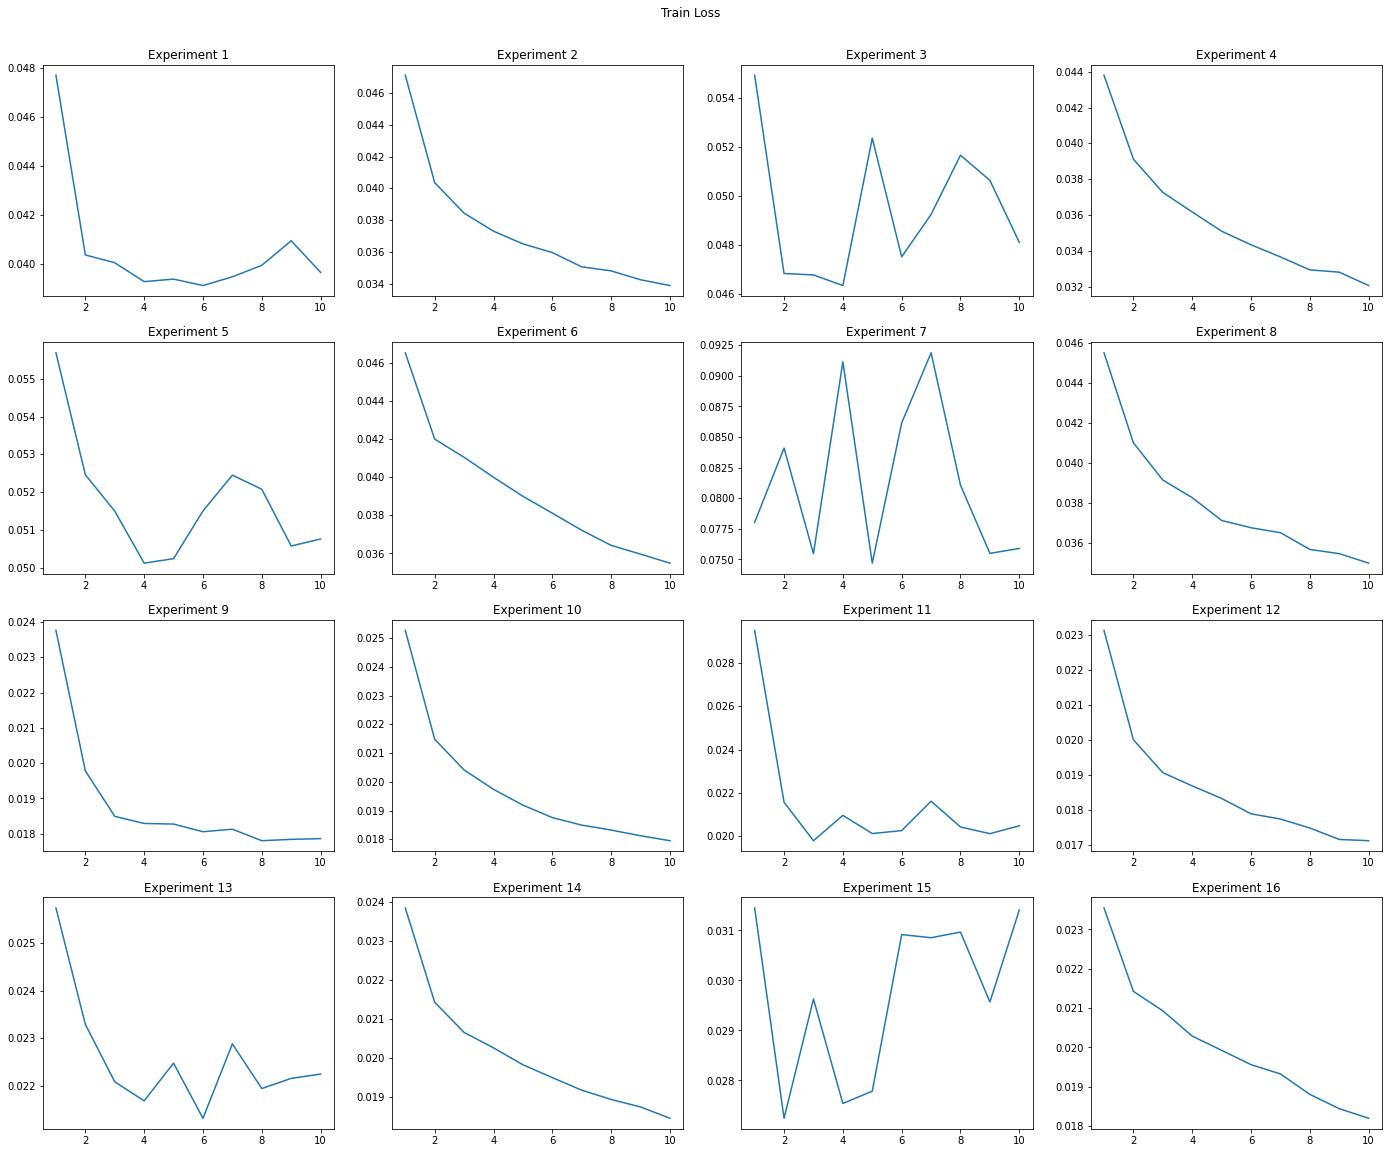

In [ ]:
# Plot the Training Loss Graphs of Experiments.
fig = plt.figure(figsize=(24, 40))

for i in range(1, len(experiment_losses) + 1):
    plt.subplot(8, 4, i).set_title(f'Experiment {i}')
    plt.plot(range(1, 11), experiment_losses[i-1])

plt.suptitle("Train Loss", y = 0.9)
plt.show()

### Two Convolutional with Two Fully Connected Layer CNN Experiments

**Experiments**

In [ ]:
# List to Hold Train Losses of Each Experiment.
experiment_losses = []

# Test the CNN which Contains Two Convolutional and Two Fully Connected Layer with Different Parameters.
for batch_size in [32, 64]:
    image_size, batch_size, train_loader, test_loader = data_load(32, batch_size)
    for i, activator in enumerate([nn.ReLU(), nn.Tanh()]):
        for learning_rate in [0.010, 0.020]:
            for optimizer_type in ['adam', 'sgd']:
                model = CNN_2(activator)
                experiment_losses.append(train_cnn(model, optimizer_type, learning_rate, train_loader))
                accuracy = test_cnn(model, test_loader)
                print(f"Batch Size: {batch_size}    Activation: {'ReLU' if i == 0 else 'TanH'}    Learning Rate: {learning_rate}    Optimizer: {optimizer_type.capitalize():4}    Test Accuracy: {accuracy:.3f}")

Batch Size: 32    Activation: ReLU    Learning Rate: 0.01    Optimizer: Adam    Test Accuracy: 0.605
Batch Size: 32    Activation: ReLU    Learning Rate: 0.01    Optimizer: Sgd     Test Accuracy: 0.574
Batch Size: 32    Activation: ReLU    Learning Rate: 0.02    Optimizer: Adam    Test Accuracy: 0.143
Batch Size: 32    Activation: ReLU    Learning Rate: 0.02    Optimizer: Sgd     Test Accuracy: 0.641
Batch Size: 32    Activation: TanH    Learning Rate: 0.01    Optimizer: Adam    Test Accuracy: 0.536
Batch Size: 32    Activation: TanH    Learning Rate: 0.01    Optimizer: Sgd     Test Accuracy: 0.632
Batch Size: 32    Activation: TanH    Learning Rate: 0.02    Optimizer: Adam    Test Accuracy: 0.426
Batch Size: 32    Activation: TanH    Learning Rate: 0.02    Optimizer: Sgd     Test Accuracy: 0.604
Batch Size: 64    Activation: ReLU    Learning Rate: 0.01    Optimizer: Adam    Test Accuracy: 0.643
Batch Size: 64    Activation: ReLU    Learning Rate: 0.01    Optimizer: Sgd     Test Accura

**Loss Graphs**

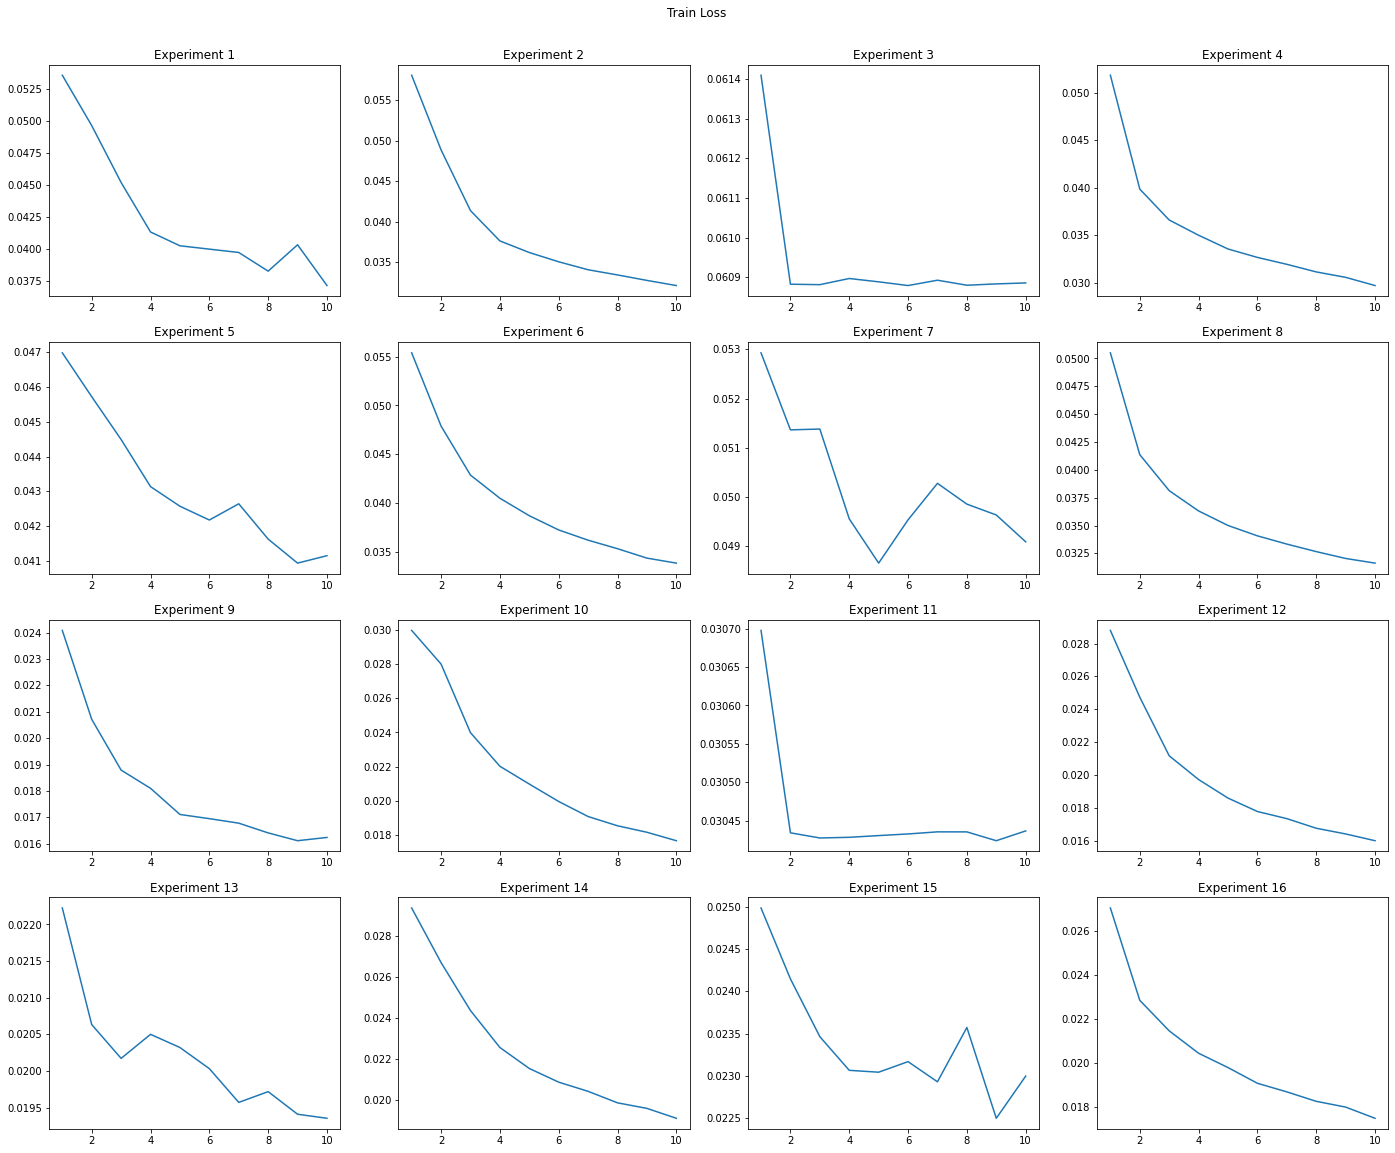

In [ ]:
# Plot the Training Loss Graphs of Experiments.
fig = plt.figure(figsize=(24, 40))

for i in range(1, len(experiment_losses) + 1):
    plt.subplot(8, 4, i).set_title(f'Experiment {i}')
    plt.plot(range(1, 11), experiment_losses[i-1])

plt.suptitle("Train Loss", y = 0.9)
plt.show()

# Bonus Part - CNN on Chest XRay Dataset

In [ ]:
# Update G-Down to avoid possible errors.
!pip install --upgrade --no-cache-dir gdown

# Download the dataset from Google Drive to Google Colab.
!gdown --id 18GFlfav8wCmuX3r0Y_BEH5imWIEK7OQT

# Extract zip files.
!unzip "chest_xray.zip" 

In [ ]:
# Create Transformers
main_transformer = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343], [0.231, 0.241, 0.241])
])

aug_transformer = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343], [0.231, 0.241, 0.241]),
    transforms.RandomErasing()
])

# Create Datasets
train_dataset = datasets.ImageFolder('/content/chest_xray/train', transform=aug_transformer)
test_dataset = datasets.ImageFolder('/content/chest_xray/test', transform=main_transformer)

# Crete Data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# CNN Model for Chest_Xray Dataset.
bonus_model = CNN_1(nn.ReLU())

In [ ]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loss = []

# Training
loss_func = nn.CrossEntropyLoss()
bonus_model.to(device)
optimizer = optim.SGD(bonus_model.parameters(), lr = 0.01)

# Run Epochs.
for epoch in range(10):
  total_loss = 0
  correct = 0
  for batch in (train_loader):
      # Grads = 0 before starting.
      optimizer.zero_grad()
      # Arrange Data.
      images = batch[0].to(device)
      labels = batch[1].to(device)
      # Forward Propagation.
      output = bonus_model(images)
      loss = loss_func(output, labels)
      total_loss += loss.item()
      _, preds = torch.max(output, 1)
      correct += (preds == labels).sum().item()
      # Backward Propagation.
      loss.backward()
      optimizer.step()
  # Train Loss on Each Epoch.
  print(f'Epoch: {epoch + 1}    Loss: {total_loss/(len(train_loader)*64)}')

Epoch: 1    Loss: 0.008208950436574982
Epoch: 2    Loss: 0.007973271501349641
Epoch: 3    Loss: 0.006714151141808388
Epoch: 4    Loss: 0.006131677724856963
Epoch: 5    Loss: 0.0062373357111627755
Epoch: 6    Loss: 0.0058174894656986
Epoch: 7    Loss: 0.005638813243267384
Epoch: 8    Loss: 0.005433938183643399
Epoch: 9    Loss: 0.0057700127709974
Epoch: 10    Loss: 0.005444113130463247


In [ ]:
# Test The Model     
bonus_model.to(device)
bonus_model.eval()
correct = 0
with torch.no_grad():
    for batch in (test_loader):
        images = batch[0].to(device)
        labels = batch[1].to(device)
        output = bonus_model(images)
        _, preds = torch.max(output.data, 1)
        correct += (preds == labels).sum().item()
    print(f'Accuracy: {correct / len(test_loader.dataset)}')

Accuracy: 0.8066666666666666


#Report

## Problem Overview

**Neural Networks are artificial intelligence that teaches computers to process data in a way that is inspired by the human brain. In this assignment, I will observe the performances of different types of Neural Networks based on parameters on the same dataset.**

## Experiment Assessments

### Single Layer Neural Network Experiment

![ResultSLP](https://drive.google.com/uc?id=1loBmHbOtwWIIJrV-qVTyPc2sYH4VJFvr)

* **In this experiment, I observed the effect of batch size, neuron count in the layer, activation function, learning rate, and optimizer effect.**
* **Batch size has both positive and negative effects on the model, most of the time increase in the batch size improves the model performance depending on other parameters.**
* **Neuron Count in Layers has both positive and negative effects on the model, most of the time increase in the neuron count improves the model performance but depending on the other parameters the increase can make the model overfit so while it has a high training accuracy, test accuracy will be low. So, choosing neuron count depending on the other parameters is too critical.**
* **The activation function affects the model performance depending on neuron saturation situations so we can't say exact things. Based on ReLU and TanH comparison for this experiment TanH achieves superiority on ReLU but works slower than ReLU. So, while choosing the activation function this profit and loss situation has to consider.**
* **Learning Rate has both positive and negative effects on the model. A higher learning rate reaches the optimality faster but also can have large errors, a slower learning rate can have small errors but also reaches the optimality slowly. In my experiment 0.01 learning rate is better than 0.02 most of the time, which means the model with learning_rate = 0.01 reaches the optimal point more successfully.**
* **The optimizer uses the Learning Rate parameter to optimize the model, based on the learning rate it optimizes the model. In my experiment, the SGD optimizer has a big superiority over the Adam optimizer. As an expert knowledge, Adam works faster than SGD but it can create more errors because of this faster converging; in my experiment, this situation occurred.**
* **When the Train Loss Graphs of experiments assessed, Adam Optimizer can't optimize the model clearly. It bulges on the graphs most of the time, that bulges mean the optimizer misses the optimal point and create occilations so loss changeable with both increasing or decreasing. On the other hand, SGD works better than Adam most of the time. In the train loss graphs of experiments which running with SGD, it decreases for each epoch and at the exact point it reaches the optimality and decrease too low. As a result, SGD works better than Adam for this experiment.**
* **Best model parameters on Single Layer Neural Network for my experiment is 32 batch size, 50 neuron in layer, ReLU activation, 0.01 Learning Rate in SGD optimizer.**

<br>

### Multi Layer Neural Network Experiment

![ResultMLP](https://drive.google.com/uc?id=18jzFZDGbX5YPriNYjwjsIc_OtmlR9Smj)

* **In this experiment, I observed the effect of batch size, neuron count in the layer, activation function, learning rate. I stabilize the optimizer as SGD as an expert knowledge from previous experiment.**
* **Increase in Batch Size affects the model badly for this experiment. This situation can create an approach about batch size & optimizer relationship. That approach is, lower batch size works better with an ideal optimizer for the problem.**
* **Decrease Neuron counts in layers affect the model positively depending on other parameters. That means when the neuron count in the layers decrease, model works more better.**
* **ReLU parameter has a superiority over TanH unlike previous experiment. In my view, that situation occurs from the increase in the hidden layer count. MLP model become more complex so TanH reach saturates some neurons and failed. ReLU prevented from the saturated neurons, so it worked better than TanH.**
* **0.02 learning rate has a superiority over 0.01 learning rate unlike previous experiment. At this point, I make sure that increase in the model complexity balanced with ReLU parameter and learning rate. This situation shows the parameters effect on the model also depending on the relationship between parameters.**
* **When the Train Loss Graphs of the Experiments assessed, SGD reaches the optimal point smoothly for all graphs. We can say the model is trained for all experiment successfully. Based on the other parameters, the curves reaches the optimality on different epochs. So, that shows us to parameters effects on the training of a model.**
* **Best model parameters on Multi Layer Neural Network for my experiment is 32 batch size, 40 - 80 neurons in layers, ReLU activation, 0.02 Learning Rate in SGD optimizer.**

<br>

### One Convolutional with One Fully Connected Layer CNN Experiment

![Result_CNN1](https://drive.google.com/uc?id=12xwV5VDgDorjPFsJ3VRy6TrU1A7IHRLA)

* **In this experiment my CNN architecture contains 1 convolutional layer and 1 fully connected layer. I observed the effect of batch size, activation function, learning rate and optimizer on the CNN.** 
* **Batch size has both positive and negative effects on the model according to results. While larger batch size works better with Adam optimizer, smaller batch size works better with SGD optimizer. So, while we choosing parameters batch size and optimizer relationship has to consider.**
* **ReLU has a superiority over TanH as observed as MLP experiment. Because Convolutional Neural Networks are more complex than MLP models. So, TanH has a disadvantage because of saturated neurons. As a result of this situaiton, ReLU is more ideal for this experiment**
* **Learning rate has both positive and negative effects on the model. Most of the time 0.01 learning rate works better depending on the other parameters but the best model created with 0.02 learning rate.**
* **SGD worked better than Adam parameter as observed as the previous classical neural network experiments. The reason of this situation is the same as classical neural network experiments.**
* **When the Train loss graphs of the experiments assessed most of the graphs bulges at the some point. That means most of the models are leads to overfit but not overfit. Independent from the optimizer, most of the graphs reaches the optimality and the slope the graph decreases smoothly.**
* **Best model parameters on One Convolutional with One Fully Conencted Layer CNN Experiment is 32 batch size, ReLU activation, 0.02 learning rate in SGD optimizer.**

<br>

### Two Convolutional with Two Fully Connecter Layer CNN Experiment

![Result_CNN2](https://drive.google.com/uc?id=19KIoXMqZd50etABa1eTVYd3FtWERJeUz)

* **In this experiment my CNN architecture contains 2 convolutional layer and 2 fully connected layer. I observed the effect of batch size, activation function, learning rate and optimizer on the CNN.**
* **Increase in the Batch Size affected the model positively most of the time. That shows the complex model can work better with larger batch sizes depending on the other parameters.**
* **ReLU and TanH are not create a superiority over each other on this experiment, so choosing an activation function for this experiment completely depends on the other choosed parameters.**
* **0.01 learning rate has a superiority over 0.02 learning rate in this experiment, that shows the model reaches the optimality with 0.01 learning rate better than 0.02 learning rate.**
* **Most of the time SGD has an superiority over Adam, and sometimes Adam works worst than a single layer neural networks. This situation proves the faster optimizer can miss the optimality with huge errors. So, choosing true optimizer is critical.**
* **When the Train loss graphs of experiments assessed, most of the time graphs creates smooth curves and reaches the optimal point at an exact epoch. But, some of the graphs shows the optimizer still an effect to create bulges. That bulges shows us the some of the models overfitted, and will fail in testing.**
* **Best model parameters on Two Convolutional with Two Fully Conencted Layer CNN Experiment is 64 batch size, ReLU activation, 0.01 learning rate in Adam optimizer.**





## Classic Neural Network vs Convolutional Neural Network

* **The main difference of classical neural networks and convolutional neural networks come from the human brain system. Classical neural networks work like a general human brain, but the convolutional neural networks work like a visual cortex of the human brain.**
* **Convolutional layers are learns the patterns of the images from low level features to high level features. So, this situation gives an advantage to Convolutional Neural Network to learn at the each layer unlike the classical neural networks learn at the last layer property.**
* **Convolutional Neural Networks are tranlation invariant because of this learn at each layer property, they can't affect from the position of the object. But the classical neural networks learn on the just last layer so they easily affect from the traslations in the images.**
* **Classical neural networks has a bigger time complexity than convolutional neural networks because while CNN has a parallel processing, Classical neural networks has to process sequentially.**
* **Classical Neural Networks can use for the primarily classification task, but Convolutional Neural Networks can use for nearly all of the classifications that a human brain can.**



## K-Nearest Neighbors vs Convolutional Neural Network

* **K-NN accuracy on first assigment changes between 0.60 - 0.70 for the Chest XRay Dataset.**
* **CNN gives 0.80 accuracy for the Chest XRay Dataset.**
* **This different causes from the working strategies and methodologies of the classifiers. KNN has no learning, it just compare the similarity/dissimilarity of the feature distances. CNN is learning the how it can distnguish the specified objects from each other. KNN has to store all the training records because it has no training step, but the CNN learns primarily to advanced features of each class from the training then check these features existence in the test images.**
* **K-NN is more simpler than CNN, so implementation of K-NN is easier than CNN.**
* **As a result, deep learning advantage of the CNN creates a superiority over K-NN for the image classification.**